![alt text](https://github.com/callysto/callysto-sample-notebooks/blob/master/notebooks/images/Callysto_Notebook-Banner_Top_06.06.18.jpg?raw=true)

In [1]:
# Import Python tools
from IPython.display import HTML
from IPython import display 
from ipywidgets import widgets
from ipywidgets import interactive

import calculate
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from plotly.offline import init_notebook_mode, iplot
import plotly.plotly as py
import plotly.graph_objs as go


init_notebook_mode(connected=True)         
import warnings

warnings.filterwarnings("ignore")
hide_me =''
HTML('''<script>
code_show=true; 
function code_toggle() {
  if (code_show) {
    $('div.input').each(function(id) {
      el = $(this).find('.cm-variable:first');
      if (id == 0 || el.text() == 'hide_me') {
        $(this).hide();
      }
    });
    $('div.output_prompt').css('opacity', 0);
  } else {
    $('div.input').each(function(id) {
      $(this).show();
    });
    $('div.output_prompt').css('opacity', 1);
  }
  code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>''')

# LA Times Analysis

## Introduction
This notebook is an extension and in some ways more transparent (if only by putting the inflation adjustments front and centre) version of the LA time article: ["Wages rise on California farms. Americans still don’t want the job"](http://www.latimes.com/projects/la-fi-farms-immigration/). In this notebook, we've made changes so you may apply the inflation adjustments yourself. You may also compare multiple state's wages against each other.

In [2]:
"""
Adjusts dollar figures for inflation using the Consumer Price Index.

Note: This function and the cpi values are taken directly from the LA times article. The
one change we have made is that our inflation adjustmetns are not just to 2015 (although, 
that might be the only year you're interested in for inflation adjustments) 
"""
cpi = {
  "1990": 130.658,
  "1991": 136.167,
  "1992": 140.308,
  "1993": 144.475,
  "1994": 148.225,
  "1995": 152.383,
  "1996": 156.858,
  "1997": 160.525,
  "1998": 163.008,
  "1999": 166.583,
  "2000": 172.192,
  "2001": 177.042,
  "2002": 179.867,
  "2003": 184.0,
  "2004": 188.908,
  "2005": 195.267,
  "2006": 201.558,
  "2007": 207.344,
  "2008": 215.254,
  "2009": 214.565,
  "2010": 218.076,
  "2011": 224.93,
  "2012": 229.6,
  "2013": 232.962,
  "2014": 236.712,
  "2015": 237.0
}

def convert_to_year(value, year, to_year):
    return (value * cpi[str(to_year)]) / cpi[str(year)] 

In [3]:
# Read in state-level data
# Because the data set takes a while to create, this is a version that we're hosting on our cloud. 
# This is slightly modified to remove the inflation correction in pre processing, as we're going to 
# show it directly here. 
state_df = pd.read_csv("https://swift-yeg.cloud.cybera.ca:8080/v1/AUTH_233e84cd313945c992b4b585f7b9125d/callysto-open-data/transformed_state.csv", dtype={"area_fips": "str"})
state_df.head()

,year,area_fips,area_title,industry_group,annual_avg_emplvl,total_annual_wages_2015,avg_annual_pay_2015
0,1990,01000,Alabama -- Statewide,crops,4206,54467330,12949.912030
1,1990,01000,Alabama -- Statewide,data,3606,66339110,18396.869107
2,1990,01000,Alabama -- Statewide,total,1600920,32767666541,20468.022475
3,1990,02000,Alaska -- Statewide,crops,124,1710636,13795.451613
4,1990,02000,Alaska -- Statewide,data,214,4770228,22290.785047


The above table displays the first few entries of the aggregated and filtered data table from the LA times analysis. We've also added a "data" industry group for future analysis, but the focus of this notebook is just on crops. What's most important to see here is that this data table contains data from more states than California. This means we can now compare multiple states against each other.

## Reproducing LA Times Results

Our first task is to reproduce the analysis of the LA Times here. Before we start comparing different states/applying different calculations. First, we shamelessly copy and paste the LA Times analysis from the notebook available on their git hub repo.  

In [4]:
# Filter that down to just California crop workers
# Here 06 is the beginning code of Califnornia. 
ca_state_df = state_df[state_df.area_fips.str.startswith("06")]
# Now we're just filtering down to only crops, and we're indexing it by year.
# an index can be thought of as the "row number" of the data table 
ca_state_crops = ca_state_df[ca_state_df.industry_group == 'crops'].set_index("year")


First, see the average anual pay of California crop workers in the cell below

In [5]:
ca_state_crops.at[2015, "avg_annual_pay_2015"]

29631.585333450963

The next step is to compare this value to the average wage crop workers were paid in 1990

In [6]:
ca_state_crops.at[1990, "avg_annual_pay_2015"]

12471.487764018

While this looks like a significant improvement, we have to remember that 1990 dollars are worth more than our inflated 2015 dollars. 

---
### Try it Out

1. Using the cells above, what pieces would you have to change to see wages in California in a different year? Try it out.

---

To make a more fair comparison, we have to first adjust the value above for inflation manually below. We note that in the LA Times article, the inflation adjustment was done behind the scenes. Not with any intention to be misleading in their analysis - it was for convenience for their presentation of data. The cells below adjust these values for comparison.

In [7]:
wage_1990 = ca_state_crops.at[1990, "avg_annual_pay_2015"]
wage_2015 = ca_state_crops.at[2015, "avg_annual_pay_2015"]

adjusted_wage_1990 = convert_to_year(value=wage_1990, year=1990, to_year=2015)

print("1990 Wage = $", adjusted_wage_1990, "\n2015 Wage = $", wage_2015)



1990 Wage = $ 22621.979519602828 
2015 Wage = $ 29631.585333450963


Where here we now see that even after adjusting for inflation, California farmers have seen a wage increase from 1990. 

---
### Try it out
 - Use the cells above to compare different years to the 2015 wages. Which values will you have to change to adjust inflation and grab correct wages?
 
 ---

The next step is to reproduce the percent change in wages (inflation adjusted) from 2010 to 2015, and compare it to the wage increases across the state. We can do this like the LA Times using their calculate module below, which is where the `percent_change` function comes from. 

In [8]:
wage_increase_crop=calculate.percentage_change(
    convert_to_year(ca_state_crops.at[2010, "avg_annual_pay_2015"], 2010,2015),
    ca_state_crops.at[2015, "avg_annual_pay_2015"]
)
print("Crop percent change = ", wage_increase_crop, "%")

Crop percent change =  13.285629671409716 %


In [9]:
ca_state_overall = ca_state_df[ca_state_df.industry_group == 'total'].set_index("year")

state_wage_increase =  calculate.percentage_change(
    convert_to_year(ca_state_overall.at[2010, "avg_annual_pay_2015"], 2010,2015),
    ca_state_overall.at[2015, "avg_annual_pay_2015"]
)
print("State percent change = ", state_wage_increase, "%")

State percent change =  6.543743486727243 %


Where this has reproduced the LA Times analysis on that section

---
### Try it out
- What was the percent change in inflation adjusted wages between 1990 and 2015? What about non-inflation adjusted?

---


We then see that the crop worker wages have increased at (slightly) more than twice the rate of wages across California in the same time frame

In [10]:
print(wage_increase_crop/state_wage_increase)


2.0302797165501865


## Reproducing the Graph

We are now in a position to reproduce the graph from the LA Times article as seen below. The first line of code below adds another column to our data table of the inflation adjusted wages before we plot it. 

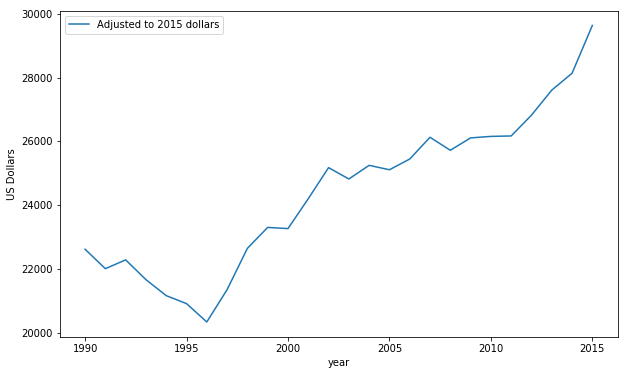

In [11]:
# Reproduce the graph
# First we create an inflation adjusted column.
# all lambda does for our purposes a way to address a function to pass
# row values to our function.  Row.name is the year as that's what we reindexed
# our data frame to earlier .
ca_state_crops["inflation_adj"] = ca_state_crops.apply(lambda row: 
                                                       convert_to_year(row.avg_annual_pay_2015, 
                                                                       row.name, 
                                                                       2015),
                                                       axis=1)

ca_state_crops.reset_index().plot(kind='line',
                                  x='year', 
                                  y=['inflation_adj'], 
                                  figsize=(10, 6),
                                  )
plt.legend(["Adjusted to 2015 dollars"])
plt.ylabel("US Dollars")
plt.show()

Where this has reporduced the graph of the LA Time article, even though it's perhaps less aesthetically pleasing.

---
### Try it out

- Try adding the non inflation adjusted plot to the graph above. This can be done in two steps
    1. Find the following line in the code above 
    ```python
    y = ['inflation_adj']
    ```
    and change it to
    ```python
    y = ['inflation_adj', avg_annual_pay_2015]
    ```
    2. Find the following line in the code above
    ```python
       plt.legend(["Adjusted to 2015 dollars"])
    ```
    and change it to
    ```python
       plt.legend(["Adjusted to 2015 dollars", "your label here"])
    ```

---

But now this might get more interesting if we begin to compare crop wages across different states directly. From this point, we are now diverging from the LA Times analysis. The information of all states can be displayed using the widget below by adjusting the drop down menus.



In [12]:
hide_me

def make_df(state, kind):
    out_df = state_df[state_df.area_title.str.match(state)]
    out_df = out_df[out_df.industry_group == str(kind)].set_index("year")
    
    out_df["inflation_adj"] = out_df.apply(lambda row: 
                                                convert_to_year(row.avg_annual_pay_2015, 
                                                row.name, 
                                                2015),
                                                axis=1)
    
    return out_df

def state_comparison(state1, state2, kind, Show_actual = True):
    # Make a temporary frame for the state and reset index so
    # years are their own column
    state1_df = make_df(state1,kind)
    state1_df = state1_df.reset_index()
    if state2:
        state2_df = make_df(state2,kind)
        state2_df = state2_df.reset_index()
    fig = plt.figure(figsize=(12, 8))
   
    plt.plot(state1_df['year'], state1_df['inflation_adj'])
    
    difference1 = state1_df.at[25, "inflation_adj"]-state1_df.at[0, "inflation_adj"]
        
    plt.legend([ "Adjusted to 2015 dollars", "No Adjustment for Inflation"])
    plt.ylabel("US Dollars", size =16)
    plt.xlabel("Year", size=16)
    # Should we want to look at another state, we plot that too and
    # adjust the trace legends
    
    if state2:
        plt.plot(state2_df['year'], state2_df['inflation_adj'])

    else:
         plt.legend(["Adjusted to 2015 dollars","No Adjustment for Inflation"])
            
    if Show_actual:
        plt.plot(state1_df['year'], state1_df['avg_annual_pay_2015'])
        plt.legend(["Adjusted to 2015 dollars","No Adjustment for Inflation"])
        if state2:
            plt.plot(state2_df['year'], state2_df['avg_annual_pay_2015'])
            
    
    if state2:
        difference2 = state2_df.at[25, "inflation_adj"]-state2_df.at[0, "inflation_adj"]
        plt.legend([
            ' '.join([state1.rstrip(" Statewide"), "Adjusted to 2015 dollars"]),
            ' '.join([state2.rstrip(" Statewide"), "Adjusted to 2015 dollars"]),
            ' '.join([state1.rstrip(" Statewide"),"No Adjustment for Inflation"]),
            ' '.join([state2.rstrip(" Statewide"),"No Adjustment for Inflation"])
          
        ])
        
        plt.title(" ".join([state1.rstrip(" Statewide"),
                            "Change in pay (2015 dollars) = $",
                            str(round(difference1,2)), '\n',
                            state2.rstrip(" Statewide"),
                            "Change in pay (2015 dollars) = $",
                            str(round(difference2,2))]))
    else:
         plt.title(" ".join([state1.rstrip(" Statewide"),
                            "Change in pay (2015 dollars) = $",
                            str(round(difference1,2))]))
        
                            
    plt.show()
    
    
choices = list(state_df["area_title"].unique())[0:-1]
choices.remove('District of Columbia')
choices2 = [None] + choices



interactive(state_comparison, state1 = choices, state2 = choices2, kind=["crops"])


interactive(children=(Dropdown(description='state1', options=('Alabama -- Statewide', 'Alaska -- Statewide', 'Arizona -- Statewide', 'Arkansas -- Statewide', 'California -- Statewide', 'Colorado -- Statewide', 'Connecticut -- Statewide', 'Delaware -- Statewide', 'Florida -- Statewide', 'Georgia -- Statewide', 'Hawaii -- Statewide', 'Idaho -- Statewide', 'Illinois -- Statewide', 'Indiana -- Statewide', 'Iowa -- Statewide', 'Kansas -- Statewide', 'Kentucky -- Statewide', 'Louisiana -- Statewide', 'Maine -- Statewide', 'Maryland -- Statewide', 'Massachusetts -- Statewide', 'Michigan -- Statewide', 'Minnesota -- Statewide', 'Mississippi -- Statewide', 'Missouri -- Statewide', 'Montana -- Statewide', 'Nebraska -- Statewide', 'Nevada -- Statewide', 'New Hampshire -- Statewide', 'New Jersey -- Statewide', 'New Mexico -- Statewide', 'New York -- Statewide', 'North Carolina -- Statewide', 'North Dakota -- Statewide', 'Ohio -- Statewide', 'Oklahoma -- Statewide', 'Oregon -- Statewide', 'Pennsylvania -- Statewide', 'Rhode Island -- Statewide', 'South Carolina -- Statewide', 'South Dakota -- Statewide', 'Tennessee -- Statewide', 'Texas -- Statewide', 'Utah -- Statewide', 'Vermont -- Statewide', 'Virginia -- Statewide', 'Washington -- Statewide', 'West Virginia -- Statewide', 'Wisconsin -- Statewide', 'Wyoming -- Statewide', 'Puerto Rico -- Statewide'), value='Alabama -- Statewide'), Dropdown(description='state2', options=(None, 'Alabama -- Statewide', 'Alaska -- Statewide', 'Arizona -- Statewide', 'Arkansas -- Statewide', 'California -- Statewide', 'Colorado -- Statewide', 'Connecticut -- Statewide', 'Delaware -- Statewide', 'Florida -- Statewide', 'Georgia -- Statewide', 'Hawaii -- Statewide', 'Idaho -- Statewide', 'Illinois -- Statewide', 'Indiana -- Statewide', 'Iowa -- Statewide', 'Kansas -- Statewide', 'Kentucky -- Statewide', 'Louisiana -- Statewide', 'Maine -- Statewide', 'Maryland -- Statewide', 'Massachusetts -- Statewide', 'Michigan -- Statewide', 'Minnesota -- Statewide', 'Mississippi -- Statewide', 'Missouri -- Statewide', 'Montana -- Statewide', 'Nebraska -- Statewide', 'Nevada -- Statewide', 'New Hampshire -- Statewide', 'New Jersey -- Statewide', 'New Mexico -- Statewide', 'New York -- Statewide', 'North Carolina -- Statewide', 'North Dakota -- Statewide', 'Ohio -- Statewide', 'Oklahoma -- Statewide', 'Oregon -- Statewide', 'Pennsylvania -- Statewide', 'Rhode Island -- Statewide', 'South Carolina -- Statewide', 'South Dakota -- Statewide', 'Tennessee -- Statewide', 'Texas -- Statewide', 'Utah -- Statewide', 'Vermont -- Statewide', 'Virginia -- Statewide', 'Washington -- Statewide', 'West Virginia -- Statewide', 'Wisconsin -- Statewide', 'Wyoming -- Statewide', 'Puerto Rico -- Statewide'), value=None), Dropdown(description='kind', options=('crops',), value='crops'), Checkbox(value=True, description='Show_actual'), Output()), _dom_classes=('widget-interact',))

Using the widget above, you can compare the farmers pay between to states and view the un-altered pay scales by clicking `Show_actual`. You may also adjust for inflation.  If you compare California to Minnesota for example, you'll notice that while wages increased in both states. Interestingly however,  Minnesota pays farmers consistently more than California. 

## Things to consider from the plot above
Check the traces for any states you're interested in. One question that you may ask could come from the trace of Hawaii once adjusted for inflation. Farmer's ages there declined from 1995 to 2004. A great research question for students may be to investigate _why_ that may be the case and what events lead to that change. Additionally, Hawaii bounces back after 2005, what events took place that could cause that? 

Other interesting questions could be more basic such as the actual wages vs. inflation or even comparing two states . Certainly, a  interesting case study may be Puerto Rico, however that will be shown more directly in the next section

## Which states have the highest and lowest farmer wages?

With all this data that seems to be a natural next question to ask, and perhaps an interesting one to ask students to figure out. Using the our already established data frame, finding these answers are straight forward. They are demonstrated below. 

In [13]:
crops_df = state_df[state_df.industry_group == 'crops'].dropna(subset=["avg_annual_pay_2015"])

# This adds a column of inflation adjusted values.
crops_df["inflation_adj"] = crops_df.apply(lambda row: 
                                           convert_to_year(row.avg_annual_pay_2015, 
                                           row.year, 
                                            2015),
                                            axis=1)


YEAR = 1990



# As we've set the index of our table to 'year', we can now pull values from a specified 
# column at a given year using the 'at' function like so 

min_pay = crops_df[crops_df.year == YEAR]["inflation_adj"].min()
max_pay = crops_df[crops_df.year == YEAR]["inflation_adj"].max()


print("Minimum pay in", YEAR, "was $", min_pay)
print("Maximum pay in", YEAR, "was $", max_pay)

Minimum pay in 1990 was $ 5661.875759686551
Maximum pay in 1990 was $ 33242.68471806703


Here we have found the minimum and maximum pay in 1990 in 2015 equivalent dollars.

---
### Try it out
- Which variable needs to be adjusted to see different years? Try finding the minimum and maximum pay in 2015 by modifying the cell above. 
- What do you think you have to modify to see minimum and maximum pay without inflation adjustments? View the non-adjusted wages in 1990 by modifying the cell above.
---





## Putting it all together in a table
Now, minimum and maximum values are great, but it will be more interesting if we're able to pull certain values, and place them in a table for further analysis. One such analysis that might be of interest is for each year, which state payed its farmers the most and the least? This is another task that can be accomplished using Python and Jupyer notebooks. 

In [14]:
# First, we add a new column which adjusts each wage to 2015 as we did before. 

# First, we sort our data frame in ascending order by their average anual pay
# before inflation adjustments 

# Add column which adjusts for inflation

crops_df = crops_df.sort_values("avg_annual_pay_2015")
crops_df["inflation_adj"] = crops_df.apply(lambda row: 
                                            convert_to_year(row.avg_annual_pay_2015, 
                                            row.year, 
                                            2015),
                                            axis=1)


# Choose the columns we care about by name
columns_to_see = ["year","area_title","avg_annual_pay_2015","inflation_adj"]


# As our data is already sorted, we now group our data by year, and choose whatever value 
# in each group using .nth(number)
# Note: Group 0 will be the smallest values, group 1 will be the second smallest etc
# to find the largest, simply enter -1, to find the second largest enter -2, etc

# Note, nth only finds the "nth position in the list". Here it cooresponds to minimum and maximum values 
# because we shorted our data table by value.


crops_df[columns_to_see].groupby('year').nth(-1)

,area_title,avg_annual_pay_2015,inflation_adj
year,,,
1990,Hawaii -- Statewide,18326.678059,33242.684718
1991,Hawaii -- Statewide,19839.010696,34529.992839
1992,Hawaii -- Statewide,20488.176716,34607.419974
1993,Hawaii -- Statewide,21065.381891,34556.120493
1994,Hawaii -- Statewide,21858.278255,34949.650507
1995,Hawaii -- Statewide,22179.137783,34495.026706
1996,Hawaii -- Statewide,21857.628090,33025.142851
1997,Hawaii -- Statewide,22308.906956,32936.993917
1998,Hawaii -- Statewide,22881.607452,33267.943697


Where in the table above we can see the highest and lowest (and everything in between) workers in each year. 

---
### Try it out
- The cell above currently prints out the highest paid states in each year. To view the lowest paid states try the following
    1. In the cell above find the line which prints the highest paid states 
    ```python
     crops_df[columns_to_see].groupby('year').nth(-1)
    ```
    and change it to 
    ```python
    crops_df[columns_to_see].groupby('year').nth(0)
    ```
    to print the lowest paid states. In this case, the `-1` specifies the last element of the list, `-2` would specify the second last element etc. 
    
    2. Change the same line to 
    ```python
       crops_df[columns_to_see].groupby('year').nth(1)
    ```
    to view the second lowest paid state
    
    3. Which state made the second highest wage in 2014?
    
---

## Creating a different kind of interactive plot
This might be more interesting to see summarized in a plot which also includes mouse hover interactivity so we can get more information from it. This is summarized below.


In [15]:
hide_me
plot_df = crops_df[columns_to_see].groupby('year').nth(-1)

# Here is an example of how a plot which hover labels is made 
traces = []
# Here we put out the names of the traces we want to put on the graph
names = ["Lowest Paid", "Second Lowest Paid", "Second Highest Paid", "Highest Paid"]

# These numbers represent the lowest, second lowest, second highest and highest paid
# farmers from the plot_df with the grouping that we saw eariler. 

for j, i in enumerate([0,1,-2,-1]):
    plot_df = crops_df[columns_to_see].groupby('year').nth(i) 
    
    # Here we're adding a trace onto the end of our data frame
    # where index is the year 
    traces.append(go.Scatter(
      x=plot_df.index,
      y=plot_df.inflation_adj,
      text = plot_df.area_title,
      name = names[j]
    ))

# Here we're formatting axis labels
layout = go.Layout(
    title='Sorted Farm Wages (2015 Dollars)',
    xaxis=dict(
        title='Year',
        titlefont=dict(
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Inflation Adjusted Wages (USD)',
        titlefont=dict(
            size=18,
            color='#7f7f7f'
        )
    )
)

fig = go.Figure(data=go.Data(traces), layout=layout)
    
iplot(fig) 

Using a plot like this it is easy to see how the maximum and minimum farmer's wages have changed accross the united states from 1990 to 2015. It is also very simple to hover your mouse over top of the graph and extra information can be digested from the plot. 

Interesting questions that could be asked to students from this plot could surround what circumstances contribute to Puerto Rico farmers are paid less than the other farmers in the United States. Often  considerably less than  the next lowest payed state to the order of $5000 dollars a year. Five thousand dollars a year is about 1/3 of Puerto Rico's maximum farmer's wage. 


Plots like this can make it interactive and natural to get students to investigate the data. Perhaps there's a trend that stands out to them - a social issue that is the cause for discrepancies between states or large fluctuations in wage from year to year. Indeed, if you find this notebook interesting, we can create something similar for use in your classroom. Provided the data exists of course.

 You can have your students interact directly with the data in a way you've seen here, or we can hide all the coding behind the scenes like we have done with the widget and the plot above. How much direct interaction you want your students to have with Python to make it through the lesson/assignment is entirely up to you.  

# Take away 

In this notebook we demonstrated how an existing social science application can be extended in your classroom in a way that will help demonstrate computational thinking, critical thinking, and research skills. It also demonstrated how you can use existing data sets to further analysis on different problems.

![alt text](https://github.com/callysto/callysto-sample-notebooks/blob/master/notebooks/images/Callysto_Notebook-Banners_Bottom_06.06.18.jpg?raw=true)